In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# ML Pipeline — Time Series Classification


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Imports
Libraries for data handling, modeling, validation, and optimization.

In [3]:
import json
import joblib # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore

from sklearn import metrics # type: ignore
from sklearn.ensemble import ( # type: ignore
    GradientBoostingClassifier,
    VotingClassifier
)
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.metrics import ( # type: ignore
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score # type: ignore

from sklearn.pipeline import Pipeline # type: ignore
from sklearn.svm import SVC # type: ignore

from catboost import CatBoostClassifier # type: ignore
import optuna # type: ignore

from kit import Data
from kit.plot import shap_catboost , run_multi_threshold_backtest,calculate_and_plot_permutation_importance,display_confusion_matrix
from kit.prep import fillna, columns_drop, apply_log, create_features, Scaler, categorize_y,drop_flat_rows

## Preprocessing

In [4]:
def process(filename, folder):
    loader = Data.Data(filename, folder)
    df = loader.data

    df = apply_log(df)
    
    df = drop_flat_rows(df, threshold=0.7)

    df = create_features(df, price_col='forward_returns')
    
    df['target'] = categorize_y(df['forward_returns'], bin=0.003)

    df = fillna(df)
    
    df = df.dropna(subset=['target'])


    split_idx = int(len(df) * 0.95)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    cols_to_drop = [
        'date_id', 'forward_returns', 'market_forward_excess_returns',
        'E7', 'M1', 'M13', 'M2', 'S3', 'V10', 'date_id'
    ]

    X_train, y_train = columns_drop(train, droplist=cols_to_drop, y_field='target')
    X_test, y_test = columns_drop(test, droplist=cols_to_drop, y_field='target')

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    return X_train, y_train, X_test, y_test

## Train / Test Split
Time-based split:
- 95% train
- 5% test

In [5]:
X_train, y_train, X_test, y_test = process("train.csv", "../Data")

In [6]:
PARAMS_FILE = "best_params_optuna.json"

def save_params(params, filename):
        with open(filename, 'w') as f:
            json.dump(params, f, indent=4)

# Hyperparameter Tuning (Optuna)

In [ ]:
def objective(trial):
    model_name = trial.user_attrs["model_name"]
    
    if model_name == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 800),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'verbose': 0, 
            'allow_writing_files': False, 
            'thread_count': -1
        }
        pipe = Pipeline([('model', CatBoostClassifier(**params))])

    elif model_name == 'SVM':
        params = {
            'C': trial.suggest_float('C', 0.1, 100, log=True),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.1, 0.01]),
            'kernel': 'rbf', 
            'class_weight': 'balanced', 
            'probability': True, 
            'cache_size': 1000
        }
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', Scaler(limits=(0.01, 0.99))),
            ('model', SVC(**params))
        ])

    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', GradientBoostingClassifier(**params))
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(pipe, X_train, y_train, cv=tscv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

models_to_tune = ['CatBoost', 'SVM', 'GradientBoosting']
best_params_found = {}

optuna.logging.set_verbosity(optuna.logging.WARNING)

for model in models_to_tune:
    study = optuna.create_study(direction='maximize')
    study.enqueue_trial({}) 
    study.set_user_attr("model_name", model)
    
    def func(trial):
        trial.set_user_attr("model_name", model)
        return objective(trial)
    study.optimize(func, n_trials=40)
    best_params_found[model] = study.best_params

save_params(best_params_found, PARAMS_FILE)

# Final Models & Ensemble

## Pipelines

In [7]:
with open("best_params_tuned.json", 'r') as f:
    tuned_params = json.load(f)

class CatBoostFlat(CatBoostClassifier): #ensures `predict()` returns a flat array.
    _estimator_type = "classifier"
    def predict(self, data, **kwargs):
        return np.array(super().predict(data, **kwargs)).ravel()

cat_p = tuned_params['CatBoost']
cat_p.update({'verbose': 0, 'allow_writing_files': False, 'thread_count': -1,'random_state': 42 })
pipe_cat = Pipeline([('model', CatBoostFlat(**cat_p))])

svm_p = tuned_params['SVM']
svm_p.update({'probability': True, 'class_weight': 'balanced'})
pipe_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Scaler(limits=(0.01, 0.99))),
    ('model', SVC(**svm_p))
])

gb_p = tuned_params['GradientBoosting']
gb_p.update({'random_state': 42})  
pipe_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('model', GradientBoostingClassifier(**gb_p))
])


vote_soft = VotingClassifier(
    estimators=[('cat', pipe_cat), ('svm', pipe_svm), ('gb', pipe_gb)],
    voting='soft',
    weights=[1, 1, 1]
)

models = {
    'Voting Soft': vote_soft,
    'CatBoost': pipe_cat,
    'SVM': pipe_svm,
    'GradientBoost': pipe_gb
}

,Accuracy,Recall,Precision,F1-Score
Modèle,,,,
CatBoost,46.44%,41.91%,42.41%,35.77%
GradientBoost,45.33%,42.09%,41.51%,39.12%
Voting Soft,44.89%,40.60%,37.30%,34.56%
SVM,40.44%,37.76%,36.11%,32.80%


## CV Strategy

In [ ]:
def cv_all_models(models_dict, X_full, y_full, n_splits=5, filename="cv_results.csv"):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    results = []

    for name, model in models_dict.items():

        scores = cross_val_score(
            model,
            X_full,
            y_full,
            cv=tscv,
            scoring='accuracy',
            n_jobs=-1
        )

        results.append({
            "Model": name,
            "CV Mean Accuracy": np.mean(scores),
            "CV Std": np.std(scores),
            "CV Min Accuracy": np.min(scores)
        })

    df_cv = pd.DataFrame(results).set_index("Model")

    display(df_cv.style.format({
        "CV Mean Accuracy": "{:.2%}",
        "CV Std": "{:.2%}",
        "CV Min Accuracy": "{:.2%}"
    }))

    df_cv.to_csv(filename)

    return df_cv

X_full = pd.concat([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

cv_results = cv_all_models(models, X_full, y_full, n_splits=5)

In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Modèle': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_pred, average='macro')
    })

df_final = pd.DataFrame(results).set_index('Modèle').sort_values(by='Accuracy', ascending=False)
df_final.to_csv("test_on_test.csv")

df_final.style.format("{:.2%}")\
    .background_gradient(cmap='RdYlGn', subset=['Accuracy', 'F1-Score','Recall','Precision'])

# Test Evaluation

In [9]:
def display_metrics(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred, average='macro')
    prc = metrics.precision_score(y_test, y_pred, average='macro')
    f1  = metrics.f1_score(y_test, y_pred, average='macro')
    
    print('Accuracy    : {:.2f}%'.format(acc*100))
    print('Recall      : {:.2f}%'.format(rec*100))
    print('Precision   : {:.2f}%'.format(prc*100))
    print('F1-score    : {:.2f}%'.format(f1*100))

In [10]:
vote_soft.fit(X_train, y_train)
y_pred = vote_soft.predict(X_test)

display_metrics(y_test , y_pred)

Accuracy    : 44.67%
Recall      : 40.41%
Precision   : 36.09%
F1-score    : 34.41%


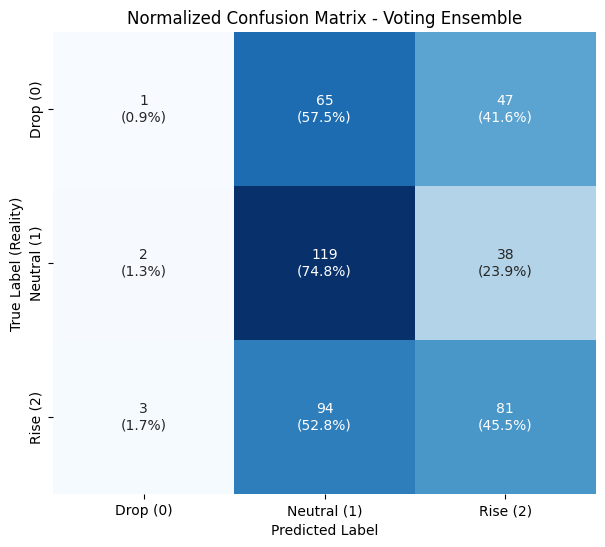

              precision    recall  f1-score   support

    Drop (0)       0.17      0.01      0.02       113
 Neutral (1)       0.43      0.75      0.54       159
    Rise (2)       0.49      0.46      0.47       178

    accuracy                           0.45       450
   macro avg       0.36      0.40      0.34       450
weighted avg       0.39      0.45      0.38       450



In [12]:
y_pred = vote_soft.predict(X_test)
labels_simple = ['Drop (0)', 'Neutral (1)', 'Rise (2)']

display_confusion_matrix(
    y_test, 
    y_pred, 
    title='Normalized Confusion Matrix - Voting Ensemble',
    labels=labels_simple,
    cmap='Blues'
)

print(classification_report(y_test, y_pred, target_names=labels_simple))


# Threshold-Based Prediction

In [11]:
def predict_with_threshold(model, X, threshold_low=0.34):
    probas = model.predict_proba(X)
    final_preds = []
    
    for p in probas:
        prob_baisse = p[0]
        if prob_baisse > threshold_low:
            final_preds.append(0) 
        else:
            final_preds.append(np.argmax(p[1:]) + 1)
            
    return np.array(final_preds)

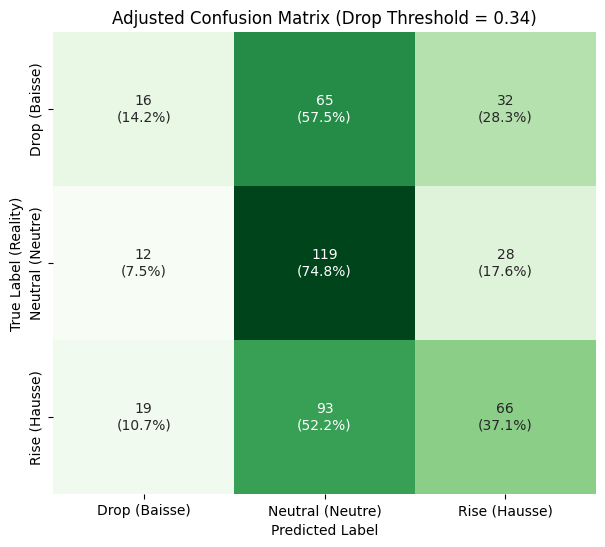

              precision    recall  f1-score   support

    Drop (0)       0.34      0.14      0.20       113
 Neutral (1)       0.43      0.75      0.55       159
    Rise (2)       0.52      0.37      0.43       178

    accuracy                           0.45       450
   macro avg       0.43      0.42      0.39       450
weighted avg       0.44      0.45      0.41       450



In [13]:
y_pred_final = predict_with_threshold(vote_soft, X_test, threshold_low=0.34)
labels_adjusted = ['Drop (Drop)', 'Neutral (Neutral)', 'Rise (Rise)']

display_confusion_matrix(
    y_test, 
    y_pred_final, 
    title='Adjusted Confusion Matrix (Drop Threshold = 0.34)',
    labels=['Drop (Baisse)', 'Neutral (Neutre)', 'Rise (Hausse)'],
    cmap='Greens'
)

print(classification_report(y_test, y_pred_final, target_names=labels_simple))

In [14]:
display_metrics(y_test , y_pred_final)

Accuracy    : 44.67%
Recall      : 42.03%
Precision   : 43.13%
F1-score    : 39.34%


# Backtest

In [16]:
loader = Data.Data("train.csv", "../Data")
df_full = loader.data

## Multi-Threshold Strategy Test

,Total Return,Sharpe Ratio,Annualized Volatility,Max Drawdown
Strategy,,,,
Model (thr=0.32),24.41%,0.75,10.84%,-15.07%
Model (thr=0.33),48.14%,1.56,11.56%,-11.02%
Model (thr=0.34),54.94%,1.66,12.41%,-11.05%
Model (thr=0.35),59.36%,1.73,12.86%,-13.62%
Market (Buy & Hold),44.03%,1.16,14.50%,-18.04%


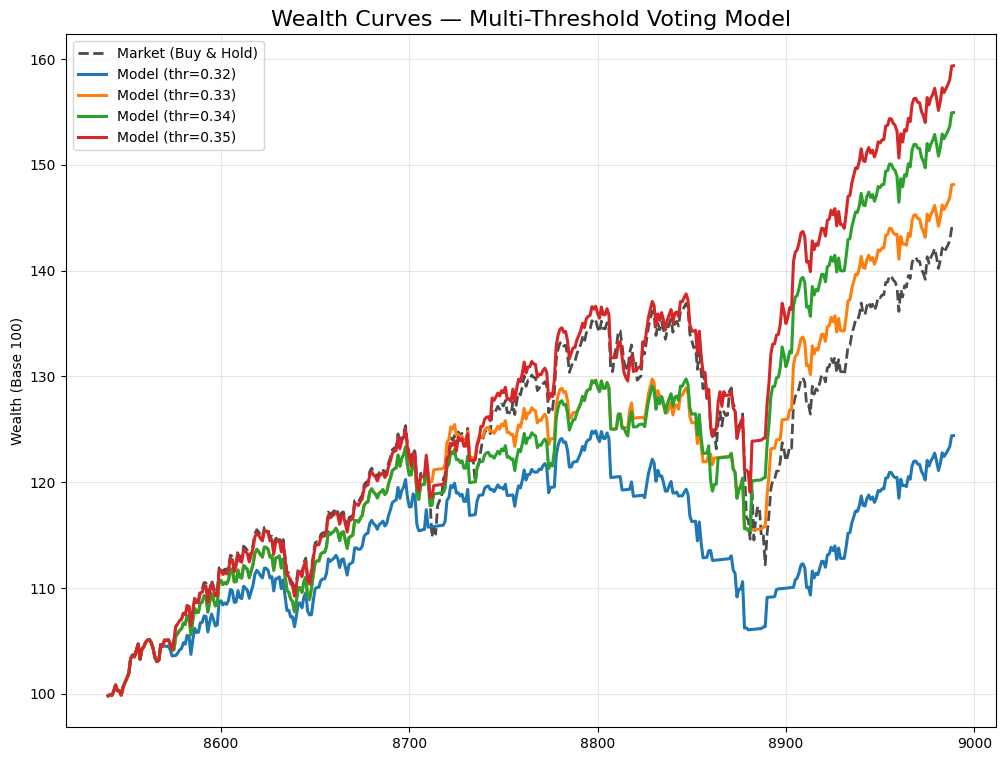

In [17]:
run_multi_threshold_backtest(vote_soft, X_test, df_full)

## Model Saving

In [18]:
joblib.dump(vote_soft,"model_voting_soft.pkl")

['model_voting_soft.pkl']

# Explainability

## Permutation Importance

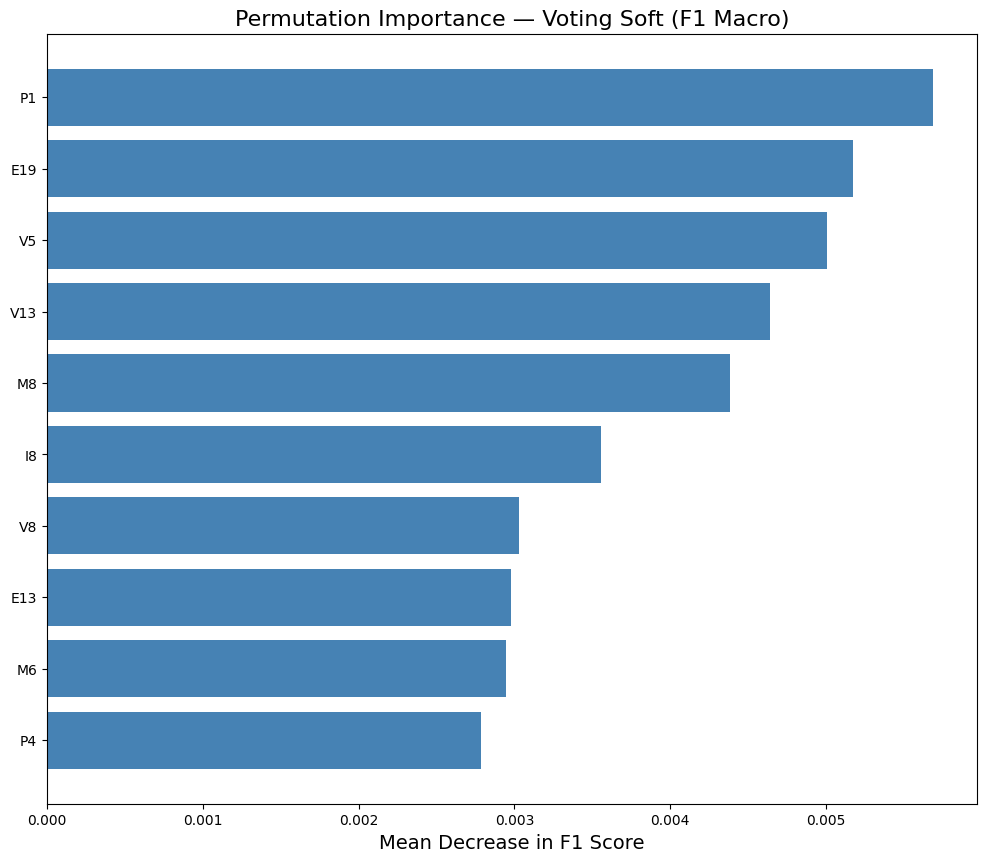

In [19]:
df_importance_final = calculate_and_plot_permutation_importance(vote_soft, X_test, y_test)

## SHAP (CatBoost)

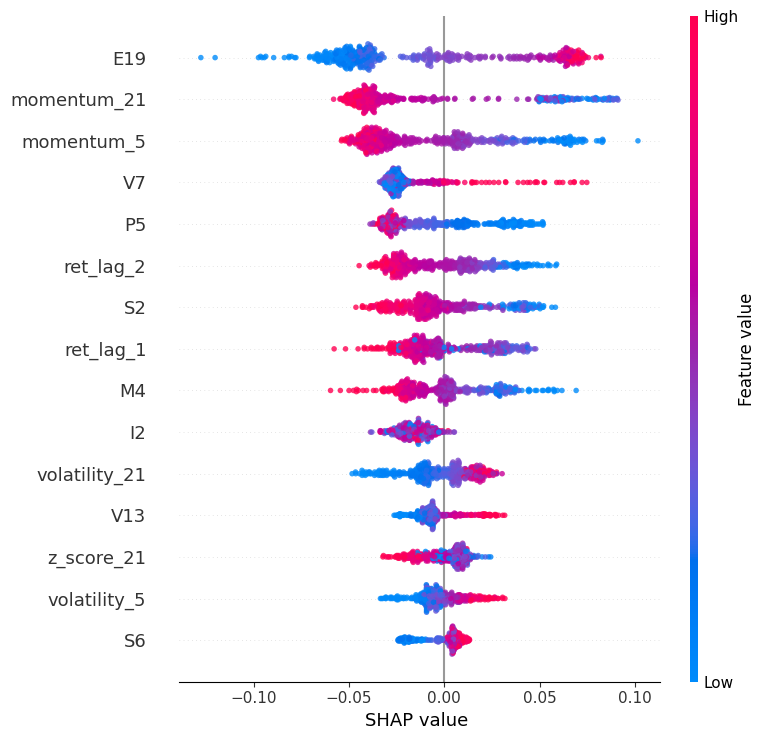

(array([[[ 8.04410714e-05,  2.50608831e-04, -1.89489020e-04, ...,
          -8.72984583e-03, -3.03554465e-02,  4.02847026e-03],
         [ 8.04410714e-05,  4.43353609e-04, -6.60462593e-05, ...,
          -1.34001919e-03, -3.47235368e-02, -1.38778566e-03],
         [ 8.04410714e-05,  4.47612107e-04, -1.89489020e-04, ...,
           1.26732183e-03, -3.28457481e-02,  1.76667243e-04],
         ...,
         [ 1.10122984e-04,  2.73191087e-04, -2.21895654e-04, ...,
          -6.74741853e-03,  4.57077462e-02,  1.18289082e-03],
         [ 1.10122984e-04,  1.99641019e-04, -1.29110335e-04, ...,
           1.53436356e-02,  1.31768537e-02,  3.81490230e-03],
         [ 8.04410714e-05,  3.75806344e-04, -1.93322841e-04, ...,
          -7.51334943e-03,  7.01970752e-02, -7.52985169e-04]],
 
        [[ 1.91253281e-05,  5.41435439e-04,  5.18926011e-04, ...,
           2.88137890e-02,  6.84737430e-02,  3.89722389e-03],
         [ 1.91253281e-05,  5.25642597e-04,  1.96555153e-04, ...,
           4.93900751

In [20]:
shap_catboost(vote_soft, X_test,classe=2)


# Summary



## What This Notebook Does
End-to-end time-series ML workflow:
- Clean + engineer features
- Create 3-class target
- Tune 3 models with Optuna
- Build soft voting ensemble
- Evaluate on holdout test
- Validate with time-series CV
- Improve Drop decision via thresholding
- Run strategy backtests
- Save model + explain predictions